<a href="https://colab.research.google.com/github/apchavezr/18.-Modelado-y-simulaci-n/blob/main/simulacion_cola_bancaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo: Simulación de una Cola Bancaria con SimPy

Este notebook implementa un modelo discreto de simulación para una cola en un banco utilizando la biblioteca `SimPy` en Python. Se modela la llegada de clientes, su atención por un único cajero y se registran los tiempos de espera.

Considere un modelo de una oficina bancaria donde los clientes llegan a razón de una persona cada 4 minutos en promedio (llegadas exponenciales), y la atención dura 3 minutos en promedio (también distribuida exponencialmente). La entidad principal son los clientes; los eventos relevantes son: llegada del cliente y fin del servicio.

En cada llegada:

*	Se registra el cliente.
*	Si hay un cajero libre, inicia el servicio.
*	Si no hay recursos disponibles, el cliente entra en la cola.

Al terminar el servicio:

*	El cliente sale del sistema.
*	Se verifica si hay más clientes esperando. Si los hay, se inicia un nuevo servicio.


Al ejecutar este código, se podrá observar:

* El flujo de clientes en el sistema.

* Los tiempos de espera individuales, útiles para evaluar la calidad del servicio.

* El tiempo promedio de espera, que sirve como métrica clave del rendimiento.

* La cantidad de clientes atendidos durante la jornada.

Este modelo puede extenderse fácilmente para incluir:

* Más cajeros (modificar capacity=1 a n).

* Priorización de clientes.

* Horarios de descanso o cierre.

* Políticas de abandono de la cola.

In [1]:
# Instalación (ejecutar si no tiene SimPy instalado)
!pip install simpy

In [2]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt

# Parámetros del sistema
TIEMPO_SIMULACION = 480       # Tiempo total en minutos (8 horas)
TIEMPO_ENTRE_LLEGADAS = 4     # Tiempo medio entre llegadas (min)
TIEMPO_ATENCION = 3           # Tiempo medio de servicio (min)

# Variables para recopilación de resultados
tiempos_espera = []
tiempos_llegada = []
tiempos_salida = []

def cliente(nombre, env, cajero):
    llegada = env.now
    tiempos_llegada.append(llegada)

    with cajero.request() as req:
        yield req
        espera = env.now - llegada
        tiempos_espera.append(espera)

        duracion = random.expovariate(1.0 / TIEMPO_ATENCION)
        yield env.timeout(duracion)

        salida = env.now
        tiempos_salida.append(salida)

def llegadas(env, cajero):
    i = 0
    while True:
        yield env.timeout(random.expovariate(1.0 / TIEMPO_ENTRE_LLEGADAS))
        i += 1
        env.process(cliente(f'Cliente {i}', env, cajero))

# Simulación
env = simpy.Environment()
cajero = simpy.Resource(env, capacity=1)
env.process(llegadas(env, cajero))
env.run(until=TIEMPO_SIMULACION)

In [3]:
# Estadísticas del sistema
promedio_espera = statistics.mean(tiempos_espera)
total_clientes = len(tiempos_espera)

print(f'Tiempo promedio de espera: {promedio_espera:.2f} minutos')
print(f'Total de clientes atendidos: {total_clientes}')

Tiempo promedio de espera: 30.04 minutos
Total de clientes atendidos: 132


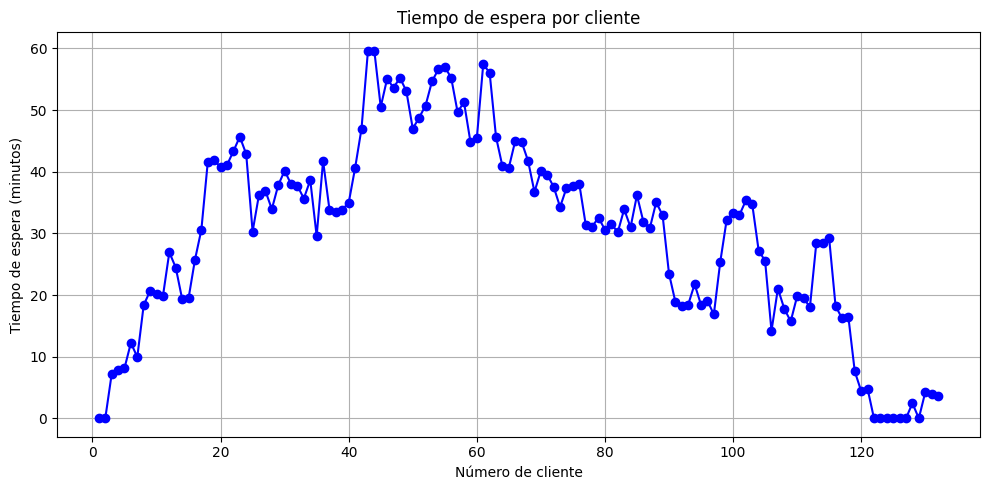

In [4]:
# Gráfico: Tiempo de espera por cliente
plt.figure(figsize=(10, 5))
plt.plot(range(1, total_clientes + 1), tiempos_espera, marker='o', linestyle='-', color='blue')
plt.title('Tiempo de espera por cliente')
plt.xlabel('Número de cliente')
plt.ylabel('Tiempo de espera (minutos)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Análisis**

* Crecimiento inicial del tiempo de espera:
    En los primeros clientes, los tiempos de espera son bajos, lo cual es coherente con el arranque del sistema vacío. Sin embargo, conforme aumentan las llegadas y se acumulan los clientes, se observa un incremento progresivo en los tiempos de espera, que alcanza su pico máximo cerca del cliente 50.

* Estabilización y congestión:
    Entre los clientes 40 y 70 se observa una fase de alta congestión, donde los tiempos de espera superan los 40 minutos de forma sostenida. Esto indica una saturación temporal del recurso (el cajero), lo cual es típico en sistemas con tasa de llegada superior a la capacidad de atención en ciertos momentos aleatorios.

**Reducción progresiva**
* A partir del cliente 70, hay una disminución gradual de los tiempos de espera. Esto puede deberse a una disminución aleatoria en la tasa de llegadas o a un ritmo de atención más eficiente, lo cual permite al sistema “descongestionarse”.

* Eventos de alivio y cola vacía:
    Hacia el cliente 120, varios puntos cercanos a cero indican momentos en que la cola se vacía completamente, y los clientes son atendidos sin esperar. Esto es un indicador de buena recuperación del sistema al final del periodo simulado.

**Conclusiones**

* El sistema presenta comportamiento no lineal y depende fuertemente de la aleatoriedad en llegadas y tiempos de atención.

* La acumulación de clientes genera cuellos de botella que afectan significativamente la experiencia del usuario (tiempo en cola).

* La gestión de recursos (por ejemplo, adicionar un segundo cajero en momentos de alta demanda) podría ayudar a mitigar los picos de espera.

* Este tipo de análisis es útil para evaluar políticas de atención y tomar decisiones sobre recursos, horarios o segmentación de clientes.